In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ultralytics import YOLO
import os
import sys
sys.path.insert(0, '../')

In [2]:
from onnx_model import ImageToWordModel
from mltu.configs import BaseModelConfigs

In [3]:
from dotenv import load_dotenv, find_dotenv
import google.generativeai as genai

In [4]:
image_path = '../sample_images/image2.png'
lines_model = YOLO('../models/detect_lines.pt')
words_model = YOLO('../models/detect_words.pt')

configs = BaseModelConfigs.load('../models/configs.yaml')
classify_word_model = ImageToWordModel(model_path='../models/classify_word.onnx', char_list=configs.vocab)

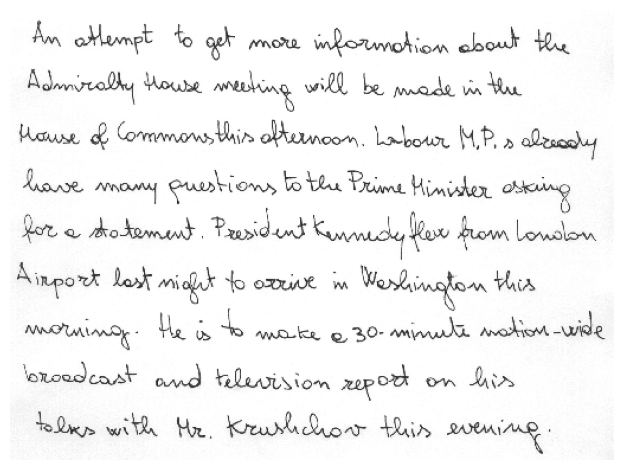

In [5]:
image = cv2.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.tight_layout()

In [6]:
def prepare_image(image):
  h,w = image.shape[:2]
  new_size = max(h,w) + 200

  padded_image = np.full((new_size, new_size, 3), (255,255,255), dtype=np.uint8)
  x_offset = (new_size-w)//2
  y_offset = (new_size-h)//2

  padded_image[y_offset:y_offset+h, x_offset:x_offset+w] = image
  return padded_image

In [7]:
def detect_lines(padded_image):
  results = lines_model.predict(padded_image, conf=0.1, iou=0.3)
  coords = []
  output_lines = []

  for result in results:
    for box in result.boxes:
      x1, y1, x2, y2 = map(int, box.xyxy[0])
      coords.append([x1,y1,x2,y2])
  
  coords = sorted(coords, key=lambda x:x[1])

  for coord in coords:
    x1,y1,x2,y2 = coord
    output_lines.append(padded_image[y1:y2, x1:x2])
    # cv2.rectangle(padded_image, (x1,y1), (x2,y2), (255,0,0), 1)

  return output_lines


(-0.5, 709.5, 709.5, -0.5)

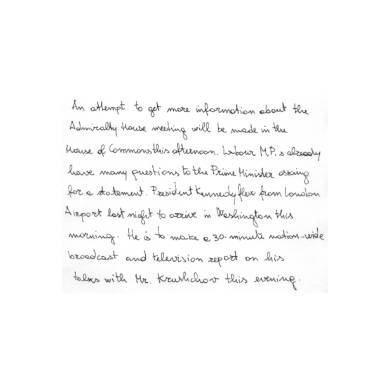

In [8]:
image = prepare_image(image)
plt.imshow(image)
plt.axis('off')

In [9]:
lines_output = detect_lines(image)



0: 640x640 9 Lines, 364.7ms
Speed: 5.1ms preprocess, 364.7ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)


(-0.5, 709.5, 709.5, -0.5)

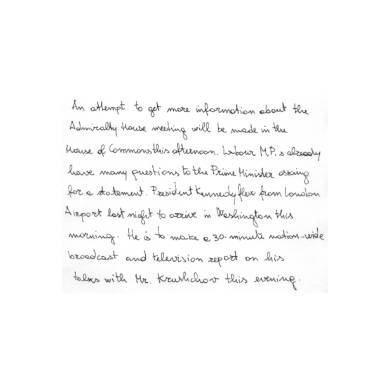

In [10]:
plt.imshow(image)
plt.axis('off')

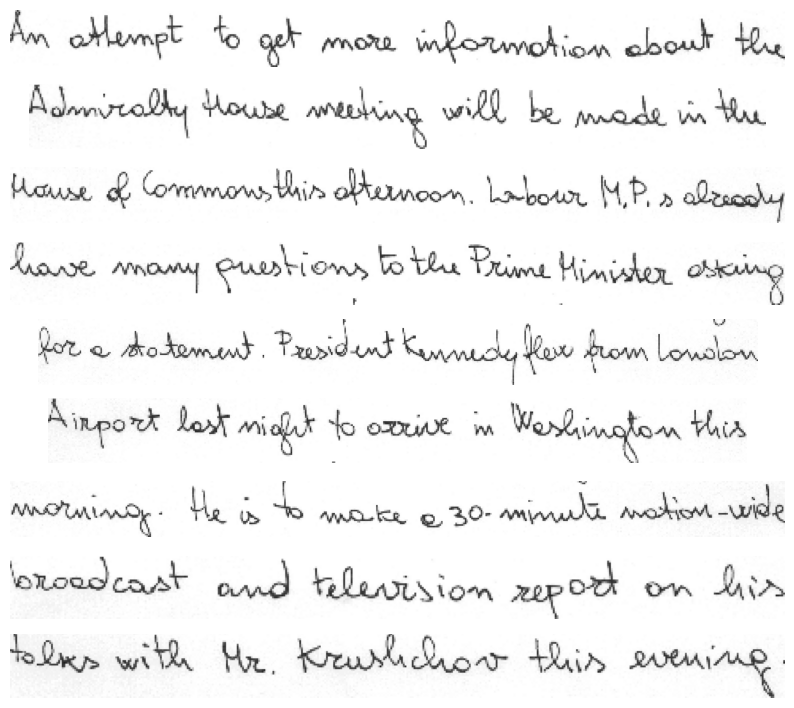

In [11]:
rows = len(lines_output)
cols = 1
k = 0
fig,axs = plt.subplots(rows, cols, figsize=(10*cols, rows))
for i in range(rows):
  axs[i].imshow(lines_output[k])
  axs[i].axis('off')
  k+=1

In [12]:
def detect_words(lines):
  words = []

  for line in lines:
    coords = []
    results = words_model.predict(line, conf=0.1, iou=0.001)
    for result in results:
      for box in result.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0])
        if (x2-x1 < 7) | (y2-y1 < 7):
          continue
        coords.append([x1,y1,x2,y2])
    
    coords = sorted(coords, key=lambda x:x[0])
    for coord in coords:
      x1,y1,x2,y2 = coord
      words.append(line[y1:y2, x1:x2])
  
  return words



0: 64x640 8 Texts, 38.3ms
Speed: 0.7ms preprocess, 38.3ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 8 Texts, 33.9ms
Speed: 1.0ms preprocess, 33.9ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 9 Texts, 32.3ms
Speed: 0.9ms preprocess, 32.3ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 9 Texts, 36.0ms
Speed: 0.8ms preprocess, 36.0ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 10 Texts, 31.5ms
Speed: 1.3ms preprocess, 31.5ms inference, 0.4ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 8 Texts, 33.9ms
Speed: 0.6ms preprocess, 33.9ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 8 Texts, 31.0ms
Speed: 0.6ms preprocess, 31.0ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 6 Texts, 33.9ms
Speed: 0.6ms preprocess, 33.9ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 640)

0: 64x640 6 Te

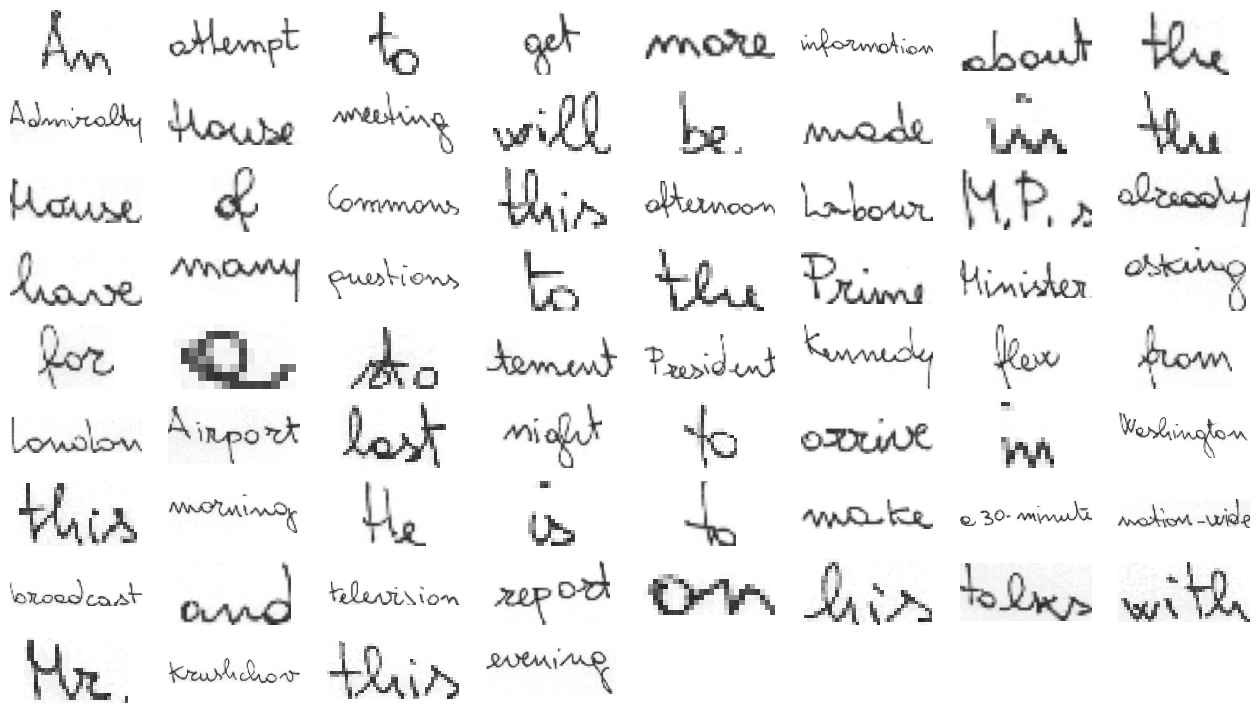

In [13]:
words_output = detect_words(lines_output)

cols = 8
rows = len(words_output)//cols+1
k = 0
fig,axs = plt.subplots(rows, cols, figsize=(2*cols, rows))
for i in range(rows):
  for j in range(cols):
    if k < len(words_output):
      axs[i][j].imshow(words_output[k])
      axs[i][j].axis('off')
      k+=1
    else:
      axs[i][j].axis('off')

In [14]:
def predict_words(words):
  output = ''
  for word in words:
    prediction = classify_word_model.predict(word)

    output += (prediction + ' ')

  return output 

In [15]:
prediction = predict_words(words_output)

In [16]:
prediction

'tn attempt to get mote inforumation about the Aaohmnisaly House mesting will be mede in the House of Commons this ohtemaon Labour Ps alicaaky have may puestions to the Preime Miinister aking foe a to temeunt Bresident Eunnuady feerr from Lonton timport bast might to oaeive in Weshington this mnrming the is to make exsomints nationciste boaedeost and television sepod on his tolres with te tamothothor this evning '

In [21]:
load_dotenv(find_dotenv())
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

In [22]:
genai.configure(api_key=GEMINI_API_KEY)
gemini_model = genai.GenerativeModel('gemini-1.5-flash')

In [23]:
prompt = f'''You will be given an input with potential typos, misspellings, and bad autocorrection: {prediction}.
Return ONLY the input after fixing any potential errors.'''

response = gemini_model.generate_content(prompt)

In [20]:
response.text

'An attempt to get more information about the  Aohmnmisaly House meeting will be made in the House of Commons this afternoon. Labour MPs already have many questions for the Prime Minister, asking for a statement. President Kennedy flew from London airport last night to arrive in Washington this morning. He is to make an important national broadcast and television report on his talks with the ambassador this evening.\n'